# 12.1 SAT 점수 해석

당신은 메사추세츠의 작은 공학대 입학처장이다.

여러면에서 자격이 유사한 두명의 지원자 __엘리스__와 __밥__ 사이에서 고민중이다.

800점 만점에서 앨리스는 780점, 밥은 740점을 받았다

앨리스가 밥보다 낫다는 것을 보여 주는 증거인지 아닌지, 그리고 그 증거의 강도가 어느 정도인지 알고 싶을 것이다.

다음과 같은 가정을 해 보자.

모든 SAT문항의 난이도가 동일하다

# 12.2 스케일

SAT 점수 산정법을 이해하자.

* 맞은 문제수에 기반한 원점수를 얻는다.
* 원점수는 200~800 범위에 있다.
* 2009년은 총 54개 문제가 출제되었다.
* 틀리게 쓴 문제에 대해서는 1/4점을 벌점으로 준다.
   

# 12.3 사전 분포

컬리지 보드는 모든 응시자에 대한 스케일된 점수의 분포도를 제공한다. 각 스케일된 저ㅁ수를 원점수로 변환한 후 문제 수로 나누면 결과는 p_correct의 추정값이 된다.

원점수의 분포를 ㅅ하용해서 p_correct의 사전 분포를 만들 수 있다.

In [ ]:
class Exam(object):
    def __init__(self):
        self.scale = ReadScale()
        scores = ReadRanks()
        score_pmf = thinkbayes.MakePmfFromDict(dict(scores))
        self.raw = self.ReverseScale(score_pmf)
        self.prior = DivideValues(raw, 54)

self.scale은 원점수를 스케일된 점수로 변환하고 원래대로 되돌리는 Interpolator이다.

scores는 (점수, 빈도) 쌍 리스트이다.

score_pmf는 스케일된 점수의 Pmf다.

self.raw는 원점수의 Pmf다

self.prior는 p_correct의 Pmf다.

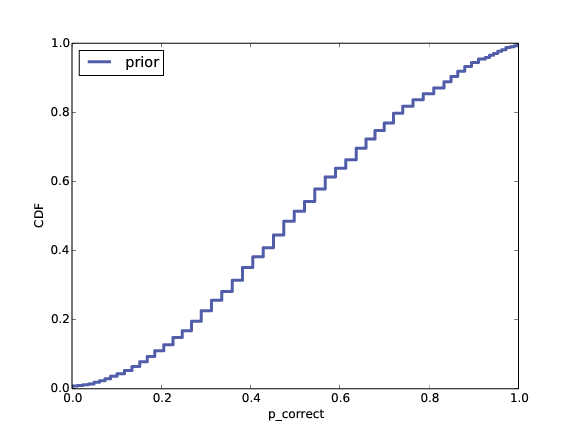

In [7]:
from wand.image import Image as WImage
WImage(filename='./figures/sat_prior.pdf')

이 분포는 __근사 가이시안__이지만 양 극값이 압축되어 있다. SAT는 평균에서 2시그마 간의 응시자의 차이를 나타내는데 가장 강력하게 사용되고 범위 밖의 응시자에 대해서는 힘이 약하다.

In [ ]:
class Sat(thinkbayes.Suite):
    def __init__(self, exam, score):
        thinkbayes.Suite.__init__(self)
        
        self.exam = exam
        self.score = score
        
        # start with the prior distribution
        for p_correct, prob in exam.prior.Items():
        self.Set(p_correct, prob)
        
        # update based on an exam score
        self.Update(score)

\__init\__은 Exam 객체와 스케일 된 점수값을 사용한다. 이 함수에서는 사전 분포의 복사본을 만들고 시험 점수 기반으로 이를 갱신

Suite의 Update를 상속하고 Likelihood 함수를 제공한다.

In [ ]:
def Likelihood(self, data, hypo):
    p_correct = hypo
    score = data
    k = self.exam.Reverse(score)
    n = self.exam.max_score
    like = thinkbayes.EvalBinomialPmf(k, n, p_correct)
    return like

hypo는 p_commrect의 가설 값이며 data는 스테일 된 점수다.

n개 문제 중 k개를 맞췄을 때의 확률을 계산한 이항 분포를 우도로 사용

# 12.4 사후 분포

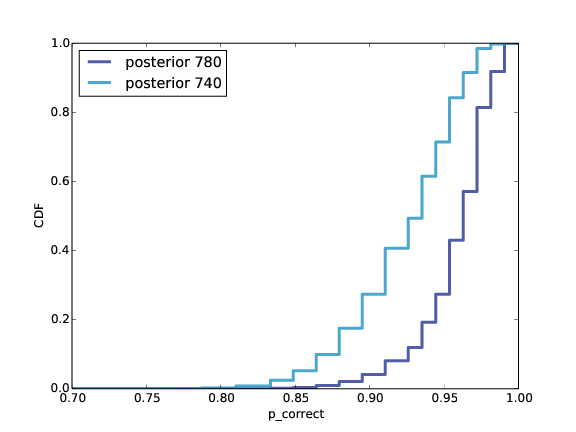

In [8]:
from wand.image import Image as WImage
WImage(filename='./figures/sat_posteriors_p_corr.pdf')

사후 분포를 도시한다. 밥에게 더 높다고 볼 수 있겠자만 가능성은 낮다.

원래 문제로 넘아가서
>"앨리스가 밥보다 더 준비된 학생일 증거는 얼마나 강력한가?"

사후 분포를 사용해서 확인 할 수도 있겠다.

베이지안 가설 검정 측면에서 이 질문을 정형화 해 보자.

* A: p_correct는 밥보다 앨리스가 더 높다.
* B: p_correct는 앨리스보다 밥가 더 높다.

A와 B의 사후 분포를 계산하는 스윗을 다음과 같이 정의할 수 있다.

In [ ]:
class TopLevel(thinkbayes.Suite):
    def Update(self, data):
        a_sat, b_sat = data

        a_like = thinkbayes.PmfProbGreater(a_sat, b_sat)
        b_like = thinkbayes.PmfProbLess(a_sat, b_sat)
        c_like = thinkbayes.PmfProbEqual(a_sat, b_sat)

        a_like += c_like / 2
        b_like += c_like / 2

        self.Mult('A', a_like)
        self.Mult('B', b_like)

        self.Normalize()

Update를 Overrite했다.

* a_like: 앨리스의 p_correct가 높을 전체 확률
* b_like: 밥의 p_correct가 높을 전체 확률
* c_like: 둘의 p_correct가 같을 전체 확률

지금 c_like를 이산형으로 처리했지만 c_like가 연속형에서는 0이 되므로 반올림이라 생각하여 양쪽에 더해 줌.

In [ ]:
exam = Exam()
a_sat = Sat(exam, 780)
b_sat = Sat(exam, 740)

top = TopLevel('AB')
top.Update((a_sat, b_sat))
top.Print()

A의 우도: 0.79, B의 우도: 0.21. 우도비는 3.8이라서 앨리스가 밥보다 잘 봤다는 증거가 된다.

# 12.5 더 나은 모델

단순 모델로 충분하다면 이번장은 넘어가라.

* 모든 시험 응시자가 동일한 efficacy/능률 정도를 가졌다고 가정한다. 이 때 능률은 SAT문제에 응답하는 척도이다.
* 각 문제는 동일한 difficulty 레벨이라고 rkwjd
* 마지막으로 시험 응시자가 문항을 정확히 맞출 확률은 다음 함수에 따라 efficacy와 difficulty가 관련된다고 가정

In [ ]:
def ProbCorrect(efficacy, difficulty, a=1):
    return 1 / (1 + math.exp(-a * (efficacy - difficulty)))

이 함수는 아이템 응답이론에서 사용되는 곡선의 단순화 버전이다.

efficacy와 difficulty는 동일한 스케일 상에 있고 질문에 바르게 응답할 확률은 두 값의 차이에 따라서만 달라진다. efficacy와 difficulty가 같을 때 응답할 확률은 50%이다.

* efficacy가 증가함에 따라서 이 활률은 100%로 올라간다.
* difficulty가 증가함에 따라서 이 확률은 0%로 내려간다.

In [ ]:
def PmfCorrect(efficacy, difficulties):
    pmf0 = thinkbayes.Pmf([0])

    ps = [ProbCorrect(efficacy, diff) for diff in difficulties]
    pmfs = [BinaryPmf(p) for p in ps]
    dist = sum(pmfs, pmf0)
    return dist

In [ ]:
def BinaryPmf(p):
    pmf = thinkbayes.Pmf()
    pmf.Set(1, p)
    pmf.Set(0, 1-p)
    return pmf

dist는 Pmf의 합이다.

In [ ]:
class Exam:
    def MakeRawScoreDist(self, efficacies):
        pmfs = thinkbayes.Pmf()
        for efficacy, prob in efficacies.Items():
            scores = PmfCorrect(efficacy, self.difficulties)
            pmfs.Set(scores, prob)

        mix = thinkbayes.MakeMixture(pmfs)
        return mix

MakeRawScoreDist는 응시자들의 efficacy의 분포를 나타내는 Pmf인 efficacies를 받는다.

# 12.6 보정

난이도의 분포가 주어진다면 MakeRawScoreDist를 사용해서 원점수의 분포를 구할 수 있다. 하지만 우리의 문제는 원 점수의 분포를 받아서 난이도의 분포를 추론하는 것이다.

난이도가 center와 width에 대한 균등 분포를 따른다고 가정하자. MakeDiffculties는 다음 변수를 사용하여 난이도의 리스트를 만든다.

In [ ]:
def MakeDifficulties(center, width, n):
    low, high = center-width, center+width
    return numpy.linspace(low, high, n)

center=-0.05, width=1.8 일 때, 원점수의 분포가 아래와 같다.

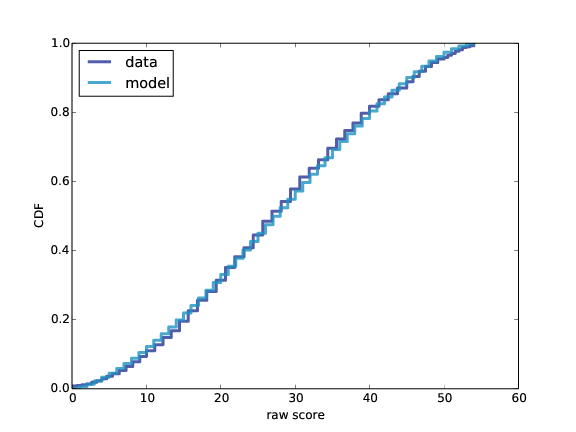

In [12]:
from wand.image import *
Image(filename='./figures/sat_calibrate.pdf')

|efficacy|-1.85|-0.05|1.75|
|-|-|-|-|
|3.00 |0.99 |0.95 |0.78|
|1.50 |0.97 |0.82 |0.44|
|0.00 |0.86 |0.51 |0.15|
|-1.50 |0.59 |0.19 |0.04|
|-3.00 |0.24 |0.05 |0.01|

# 12.7 효과의 사후 분포

새로운 Sat 클래스이다.

In [ ]:
class Sat2(thinkbayes.Suite):
    def __init__(self, exam, score):
        self.exam = exam
        self.score = score

        # start with the Gaussian prior
        efficacies = thinkbayes.MakeGaussianPmf(0, 1.5, 3)
        thinkbayes.Suite.__init__(self, efficacies)
        
        # update based on an exam score
        self.Update(score)

In [ ]:
def Likelihood(self, data, hypo):
    efficacy = hypo
    score = data
    raw = self.exam.Reverse(score)

    pmf = self.exam.PmfCorrect(efficacy)
    like = pmf.Prob(raw)
    return like

우도비는 3.4로 3.8보다 약간 작다. 따라서 이 모델은 데이터가 A에 대한 증거가 된다는 것을 가리키지만 앞에 분석에서 보다 약간 약하기는 하다.

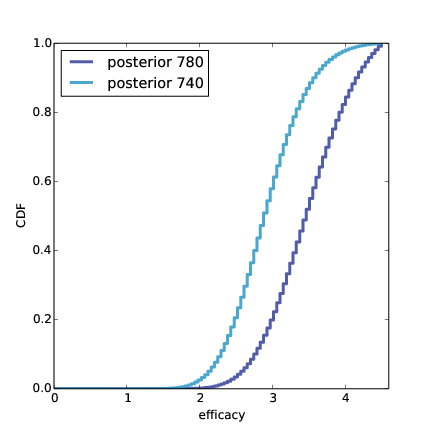

In [13]:
from wand.image import *
Image(filename='./figures/sat_posteriors_eff.pdf')

# 12.8 예측 분포

지금까지 해 온 분석을 통해 앨리스와 밥의 효과를 추정했지만 효과를 정확히 관측하기 어려운 관계로 이결과를 증명하기는 어렵다.

>"만약 앨리스와 밥이 SAT 수학 시험을 다시 친다면 여전히 앨리스의 성적이 더 높을 확률은 얼마인가?"

다음의 두단계로 구해 보자.
* 효율의 사후 분포를 사용해서 각 시험 응시자의 원점수에 대한 예측 확률을 생성할 것이다.
* 두 예측 확률을 비교해서 또 앨리스의 성적이 더 높을 확률을 계산할 ㄱ덧이다.



In [ ]:
exam = Exam()
a_sat = Sat(exam, 780)
b_sat = Sat(exam, 740)

a_pred = exam.MakeRawScoreDist(a_sat)
b_pred = exam.MakeRawScoreDist(b_sat)

In [ ]:
a_like = thinkbayes.PmfProbGreater(a_pred, b_pred)
b_like = thinkbayes.PmfProbLess(a_pred, b_pred)
c_like = thinkbayes.PmfProbEqual(a_pred, b_pred)

앨리스가 두번째 시험엣허 더 성적이 좋을 확률은 63%, 밥이 더 시험을 잘 보거나 동일할 확률은 37%이다.

앨리스의 효율이 더 높을 것에 대한 사후 승산비는 3:1이나 다음 시험에서 앨리스가 더 성적이 좋은 것에 대한 비는 2:1 밖에는 안된다.

# 12.9 토의

이 장의 시작부에 다음의 질문을 했다.
>"앨리스가 밥보다 더 준ㅌ비된 학생이라는 증거는 얼마나 강력한가?"

가설에 대한 우도를 계산하는 대신, 추정 문제를 풀어야 한다. 각 시험 응시자에 대해 p_correct나 efficacy에 대한 사후 분포를 찾아내야 한다.

이런 값처럼 우리가 그 값이 얼마인지 알 필요는 없지만, 추정해야 하는 값을 가리켜 __장애모수__라 한다.

이 모수 공간을 그래프로 나타내서 지금까지 한 분석을 시각화할 수 있다. thinkbayes.MakeJoint는 두 Pmf를 취해서 결합 확률을 계산하고 능한 값의 쌍과 이 쌍이 나타날 확률의 결함 Pmf를 반환한다.

In [ ]:
def MakeJoint(pmf1, pmf2):
    joint = Joint()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            joint.Set((v1, v2), p1 * p2)
    return joint

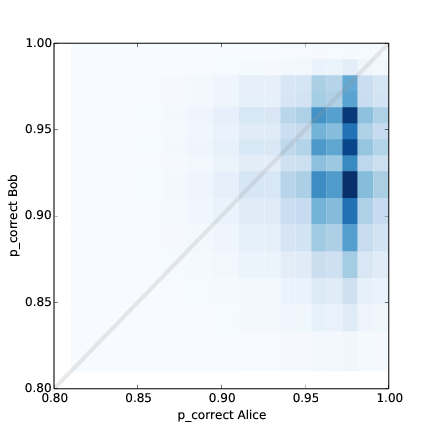

In [14]:
from wand.image import *
Image(filename='./figures/sat_joint.pdf')

앨리스와 밥의 p_correct의 결합 사후 확률 분포를 나타낸다. 대각선은 p_correct가 앨리스와 밥에 대해 동일한 부분을 가리킨다. 이선의 오른쪽은 앨리스가 더 준비된 경우고 왼쪽은 밥이 더 준비된 경우다.

# Thank u so much! Q & A